# CORD-19 text analysis

In this notebook, we perform a topic modelling analysis of CORD-19 publications.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, pickle
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [2]:
# load metadata (follow the other notebooks in the repository to create these)

df_meta = pd.read_csv("datasets_output/df_pub.csv",compression="gzip")
df_datasource = pd.read_csv("datasets_output/sql_tables/datasource.csv",sep="\t",header=None,names=['datasource_metadata_id', 'datasource', 'url'])
df_pub_datasource = pd.read_csv("datasets_output/sql_tables/pub_datasource.csv",sep="\t",header=None,names=['pub_id','datasource_metadata_id'])
df_cord_meta = pd.read_csv("datasets_output/sql_tables/cord19_metadata.csv",sep="\t",header=None,names=['cord19_metadata_id', 'source', 'license', 'full_text_file', 'ms_academic_id',
       'who_covidence', 'sha', 'full_text', 'pub_id'])

In [3]:
df_meta.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,timestamp
0,0,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020.0,NaN,Science,NaN,NaN,NaN,0.1126/science.abb7331,NaN,NaN,2020-04-04 07:55:51.892454
1,1,[Ten hot issues of breast cancer under the nov...,NaN,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,32036640.0,NaN,2020-04-04 07:55:51.892454
2,2,Another Piece of the Puzzle: Human Metapneumov...,BACKGROUND: Each winter respiratory viruses ac...,2008.0,12.0,Archives of Internal Medicine,NaN,NaN,NaN,10.1001/archinte.168.22.2489,19064834.0,PMC2783624,2020-04-04 07:55:51.892454
3,3,Viral etiology of severe pneumonia among Kenya...,CONTEXT: Pneumonia is the leading cause of chi...,2010.0,5.0,JAMA,NaN,NaN,NaN,10.1001/jama.2010.675,20501927.0,PMC2968755,2020-04-04 07:55:51.892454
4,4,Critically Ill Patients With Influenza A(H1N1)...,NaN,2014.0,4.0,JAMA,NaN,NaN,NaN,10.1001/jama.2014.2116,24566924.0,PMC6689404,2020-04-04 07:55:51.892454


In [4]:
df_meta.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'timestamp'],
      dtype='object')

In [5]:
df_datasource

,datasource_metadata_id,datasource,url
0,0,CORD19,https://pages.semanticscholar.org/coronavirus-...
1,1,Dimensions,https://docs.google.com/spreadsheets/d/1-kTZJZ...
2,2,WHO,https://www.who.int/emergencies/diseases/novel...


#### Select just CORD-19

In [6]:
df_meta = df_meta.merge(df_pub_datasource, how="inner", left_on="pub_id", right_on="pub_id")
df_meta = df_meta.merge(df_datasource, how="inner", left_on="datasource_metadata_id", right_on="datasource_metadata_id")
df_cord19 = df_meta[df_meta.datasource_metadata_id==0]
df_cord19 = df_cord19.merge(df_cord_meta, how="inner", left_on="pub_id", right_on="pub_id")

In [7]:
df_meta.shape

(56809, 16)

In [8]:
df_cord19.shape

(46994, 24)

In [9]:
# publications without DOI will be missing from the network clustering analysis

df_cord19[pd.isnull(df_cord19["doi"])].shape

(3038, 24)

In [10]:
# we save a list of DOIs to filter data from Dimensions for the network clustering analysis (see notebook 3)

pickle.dump(df_cord19[pd.notnull(df_cord19["doi"])]["doi"].to_list(),open("datasets_output/networks/cord-19-dois.pk","wb"))

## Text analysis

In [11]:
# TODO: add a language detection to remove all non-English

In [12]:
df_cord19[df_cord19["abstract"]==""].shape

(0, 24)

In [13]:
# concatenate abstracts and titles

# note that ~8k articles have no abstract
df_cord19["title"] = df_cord19["title"].fillna('')
df_cord19["abstract"] = df_cord19["abstract"].fillna('')
df_cord19["title_abstract"] = df_cord19.title +" "+df_cord19.abstract

In [14]:
#texts = df_cord19[(pd.notnull(df_cord19["title_abstract"])) & (df_cord19.publication_year>2019)].title_abstract.tolist()
texts = df_cord19[(pd.notnull(df_cord19["title_abstract"]))].title_abstract.tolist()
texts[0]

'‘A ticking time bomb’: Scientists worry about coronavirus spread in Africa CAPE TOWN, SOUTH AFRICA—Late on Sunday evening, South African President Cyril Ramaphosa, in a televised address to the nation, declared that COVID-19, the respiratory disease spreading globally, had become a “national disaster.” The declaration allows his government to access special funding and instigate harsh regulations to combat the viral outbreak. “Never before in the history of our democracy have we been confronted by such a severe situation,” Ramaphosa said before announcing a raft of measures to curb the virus’ spread, including school closures, travel restrictions, and bans on large gatherings. So far, the official numbers seemed to suggest that sub-Saharan Africa, home to more than 1 billion people, had been lucky. The interactive map of reported COVID-19 cases run by Johns Hopkins University shows big red blobs almost everywhere—except sub-Saharan Africa.'

#### Topic modelling

In [15]:
from tqdm import tqdm
import gensim, sklearn
import scispacy
import spacy
import pyLDAvis.gensim

In [ ]:
!python -m spacy download en

In [14]:
#nlp = spacy.load('en')
nlp = spacy.load("en_core_sci_md")
#STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
%%time

# pre-processing: use lemmas and remove stopwords, add entities

processed_docs = list()
for doc in nlp.pipe(texts, n_process=6, batch_size=100):

    ents = doc.ents  # Named entities

    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]# token.is_alpha]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    #doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than one word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
                        
    processed_docs.append(doc)

In [ ]:
import pickle

pickle.dump(processed_docs, open("datasets_output/texts/processed_docs_cord19_scispacy.pk", "wb"))

In [16]:
import pickle

processed_docs = pickle.load(open("datasets_output/texts/processed_docs_cord19_scispacy.pk", "rb"))

In [17]:
docs = processed_docs
del processed_docs

# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear several times or more). A better approach would be to use a chi_sq test.
bigram = Phrases(docs, min_count=50)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [18]:
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 10

In [19]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of docs: %d (%d)' % (len(corpus),len(texts)))

Number of unique tokens: 29136
Number of docs: 46994 (46994)


In [20]:
dictionary.token2id["covid-19"]

20

In [21]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 15,'passes': 10, 'random_state': seed}
model = LdaModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 4min 4s, sys: 847 ms, total: 4min 5s
Wall time: 3min 54s


In [22]:
model.show_topics(num_words=10, num_topics=params['num_topics'])

[(0,
  '0.017*"health" + 0.014*"disease" + 0.008*"public" + 0.008*"datum" + 0.007*"model" + 0.007*"outbreak" + 0.006*"public_health" + 0.006*"infectious" + 0.006*"epidemic" + 0.006*"system"'),
 (1,
  '0.031*"cell" + 0.018*"mouse" + 0.018*"infection" + 0.017*"response" + 0.012*"immune" + 0.010*"expression" + 0.009*"t" + 0.007*"disease" + 0.007*"induce" + 0.006*"role"'),
 (2,
  '0.048*"virus" + 0.043*"cell" + 0.017*"protein" + 0.016*"viral" + 0.014*"replication" + 0.012*"infection" + 0.011*"hepatitis" + 0.007*"mhv" + 0.006*"mutant" + 0.006*"result"'),
 (3,
  '0.019*"group" + 0.018*"=" + 0.015*"study" + 0.013*"day" + 0.013*"p" + 0.010*"high" + 0.009*"level" + 0.009*"cat" + 0.008*"<" + 0.008*"effect"'),
 (4,
  '0.020*"infection" + 0.020*"dog" + 0.015*"hospital" + 0.015*"canine" + 0.014*"transmission" + 0.013*"h1n1" + 0.013*"worker" + 0.013*"contact" + 0.012*"pandemic" + 0.011*"air"'),
 (5,
  '0.026*"calf" + 0.021*"strain" + 0.019*"isolate" + 0.017*"rotavirus" + 0.015*"bovine" + 0.014*"diar

In [252]:
# printout for LaTeX
#for t in model.show_topics(num_words=20, num_topics=params['num_topics'], formatted=False):
#    print("\\item \\textbf{Topic #%d}"%t[0]+": "+"``"+"'', ``".join([w[0] for w in t[1] if len(w[0])>2])+"''.")

In [23]:
# plot topics (NOTE: the IDs here do not match those from the model)
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [24]:
# topics over time

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
publication_years = df_local.publication_year.tolist()
dois = df_local.doi.tolist()
topics = np.zeros((len(docs),params['num_topics']))

for n,doc_topics in enumerate(model.get_document_topics(corpus)):
    for t in doc_topics:
        topics[n][t[0]] = t[1]

In [25]:
topics[0,:]

array([0.58899075, 0.        , 0.02117411, 0.        , 0.        ,
       0.13432109, 0.03213535, 0.02725324, 0.        , 0.14957163,
       0.04038033, 0.        , 0.        , 0.        , 0.        ])

In [26]:
model.get_document_topics(corpus[0])

[(0, 0.58898634),
 (2, 0.021172175),
 (5, 0.13432088),
 (6, 0.032132164),
 (7, 0.027253347),
 (9, 0.14957902),
 (10, 0.04038254)]

In [27]:
df_topics = pd.DataFrame(topics)

In [28]:
df_topics["year"] = publication_years
df_topics["doi"] = dois

In [29]:
from_which_year = 1980

grouped = df_topics.groupby('year')
#grouped = df_topics[df_topics.isin({'doi': clusters[3]})["doi"]].groupby('year')
df_grouped = grouped.aggregate(np.mean)
df_grouped = df_grouped[df_grouped.index >= from_which_year]
#df_grouped

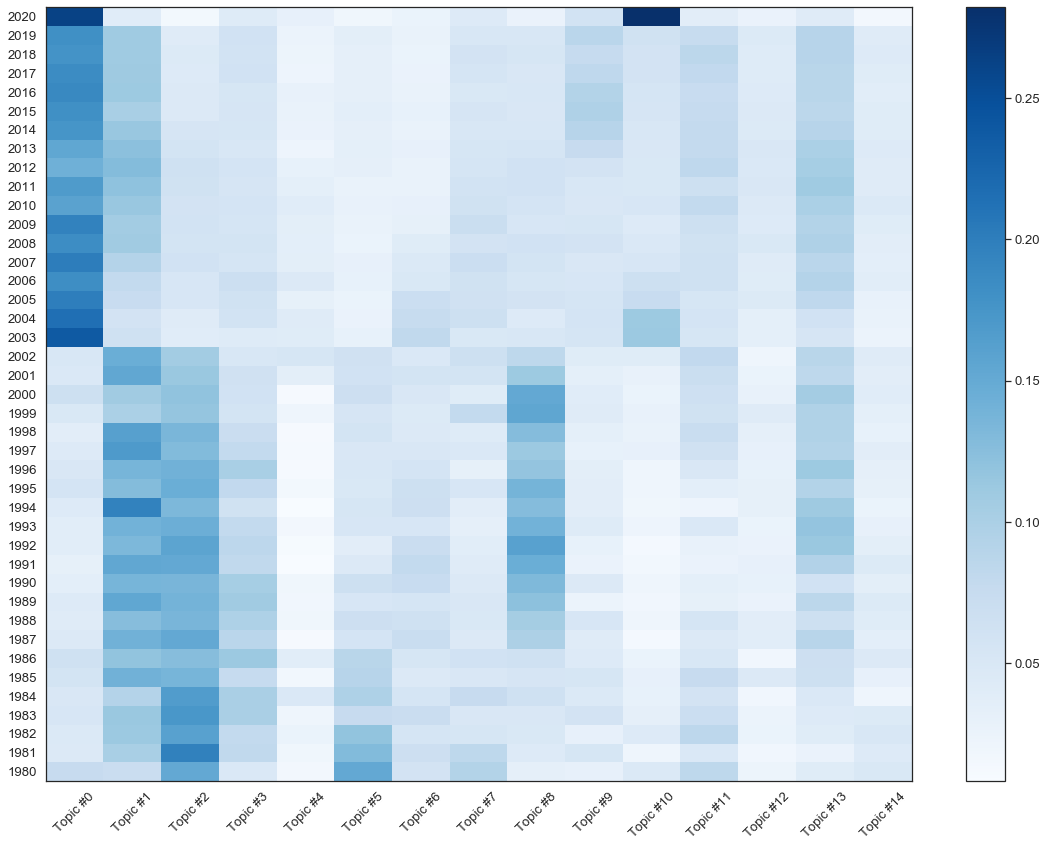

In [30]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped.index.values])
plt.xticks(np.arange(df_grouped.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(model.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
#plt.savefig("figures/topic_model_all_time_15.pdf")
plt.show()

#### Macrotopic analysis

In [209]:
# define macro topics

topic_labels = {
    "Coronavirus": [6,9,10],
    "Public health and epidemics": [0],
    "Molecular biology": [2,8,13],
    "Influenza": [4,11,14],
    "Immunology": [1],
    "Rotavirus": [5],
    "Antivirals": [12],
    "Clinical trials": [3],
    "Testing and diagnosing": [7]
}

In [210]:
# get number of papers per macro topic over time

is_selected_topic = {t:[0 for _ in range(len(docs))] for t in topic_labels.keys()}
topic_to_label = dict()
for k,v in topic_labels.items():
    for vv in v:
        topic_to_label[vv] = k
for d in range(len(docs)):
    d_topics = model.get_document_topics(corpus[d])
    for x in d_topics:
        is_selected_topic[topic_to_label[x[0]]][d] += x[1]

In [211]:
# plot trends

df_topic_intensity = pd.DataFrame.from_dict(is_selected_topic)
df_topic_intensity["year"] = publication_years
df_topic_intensity["doi"] = dois

In [221]:
from_which_year = 1980

grouped_ti = df_topic_intensity.groupby('year')
df_grouped_ti = grouped_ti.aggregate(np.mean)
df_grouped_ti = df_grouped_ti[df_grouped_ti.index >= from_which_year]

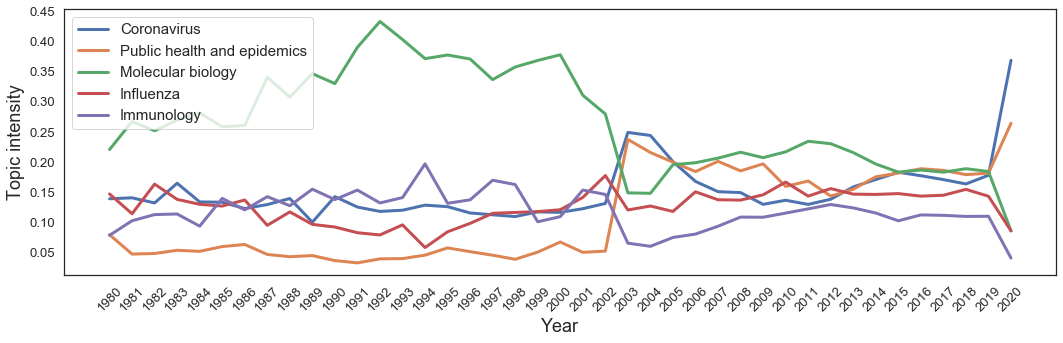

In [222]:
fig = plt.figure(figsize=(15, 5))
for k in ["Coronavirus","Public health and epidemics","Molecular biology","Influenza","Immunology"]:
    plt.plot(df_grouped_ti[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti.shape[0]), [int(x) for x in df_grouped_ti.index.values], rotation=45)
plt.legend(loc="upper left",fontsize=15)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.tight_layout()  # fixes margins
#plt.savefig("figures/topic_model_trends.pdf")

#### Network cluster to topic analysis - 1

Use the extended citation clustering and characterize with topics.

In [223]:
clustering_solution_df = pd.read_csv("datasets_input/paper_CORD19_supporting_materials/clustering_04042020.csv", sep=";",header=0)

In [224]:
clustering_solution_df.shape

(38718, 11)

In [225]:
clustering_solution_df.head()

,clusters_0,clusters_1,pub_id,title,pub_type_id,pub_year,doi,pmid,pmcid,n_cits,relative_citation_ratio
0,0,0,pub.1000004997,Emerging respiratory viral infections: MERS-Co...,1,2014,10.1016/s2213-2600(13)70255-8,24461892.0,NaN,7,"0,34"
1,8,5,pub.1000011796,Maternal vaccination: moving the science forward,1,2015,10.1093/humupd/dmu041,25015234.0,PMC4255605,33,"1,81"
2,7,4,pub.1000014854,Chapter 14 Canine Parvovirus Infections and Ot...,3,2014,10.1016/b978-1-4377-0795-3.00014-4,NaN,NaN,7,NaN
3,11,0,pub.1000017764,Effect of proactive infection control measures...,1,2015,10.1016/j.ajic.2015.04.203,26059601.0,NaN,12,"1,26"
4,3,1,pub.1000020626,Molecular Determinants of Species Specificity ...,1,2001,10.1128/jvi.75.20.9741-9752.2001,11559807.0,PMC114546,61,"1,34"


In [148]:
# clusters_0 contains smaller clusters

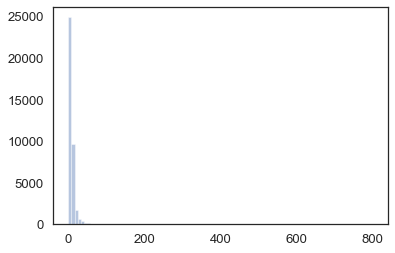

In [149]:
sns.distplot(clustering_solution_df.clusters_0.values, kde=False, norm_hist=False, bins=100)

In [150]:
# clusters_1 contains larger clusters

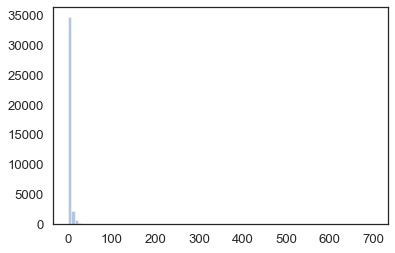

In [151]:
sns.distplot(clustering_solution_df.clusters_1.values, kde=False, norm_hist=False, bins=100)

In [239]:
which_clustering = 1

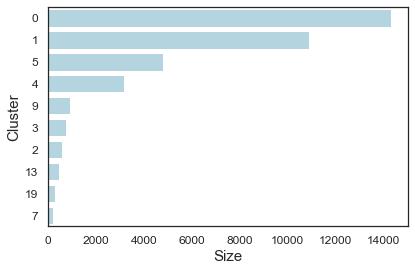

In [240]:
df_sub = clustering_solution_df[clustering_solution_df["clusters_%d"%which_clustering].isin(clustering_solution_df["clusters_%d"%which_clustering].value_counts()[:10].index.tolist())]
b = sns.countplot(y="clusters_%d"%which_clustering, data=df_sub, order=df_sub["clusters_%d"%which_clustering].value_counts().index, color='lightblue')
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Size",fontsize=15)
b.set_ylabel("Cluster",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/clustering_size_%d.pdf"%which_clustering)

In [241]:
# characterize a cluster by Macro topics

cluster_topic_join_df = clustering_solution_df.merge(df_topic_intensity, how="left", left_on="doi", right_on="doi")

In [250]:
which_cluster = 0

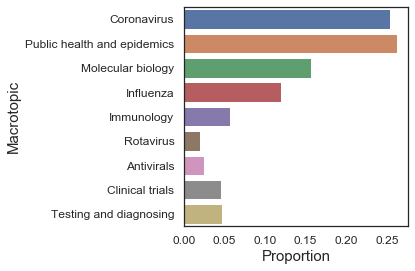

In [251]:
df_sub = cluster_topic_join_df[cluster_topic_join_df["clusters_%d"%which_clustering] == which_cluster][[mt for mt in topic_labels.keys()]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/clustering_size_%d_cluster%d.pdf"%(which_clustering,which_cluster))

#### Network cluster to topic analysis - 2

In [78]:
# check if bibliographic coupling with Dimensions data matches topic distribution. Check Noteboon 3 for this part

clusters = pickle.load(open("datasets_output/networks/clusters_doi.pk","rb"))

In [148]:
from_which_year = 1980
which_cluster = 0

grouped_ti_cl = df_topic_intensity[df_topic_intensity.isin({'doi': clusters[which_cluster]})["doi"]].groupby('year')
df_grouped_ti_cl = grouped_ti_cl.aggregate(np.mean)
df_grouped_ti_cl = df_grouped_ti_cl[df_grouped_ti_cl.index >= from_which_year]

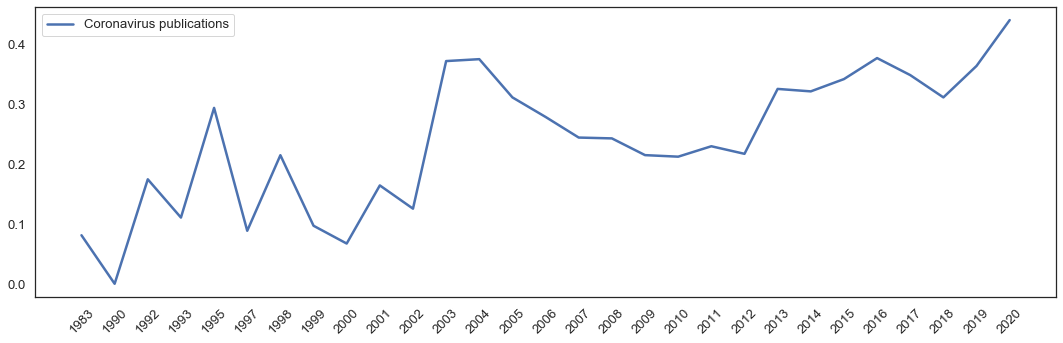

In [149]:
fig = plt.figure(figsize=(15, 5))
plt.plot(df_grouped_ti_cl.is_topic.values, label="%s publications"%which_topic)
plt.xticks(np.arange(df_grouped_ti_cl.shape[0]), [int(x) for x in df_grouped_ti_cl.index.values], rotation=45)
plt.legend()
plt.tight_layout()  # fixes margins
#plt.savefig("figures/topic_model_cluster_%d_%s.pdf"%(which_cluster,"_".join(which_topic.split())))

In [151]:
# check some publications in a given cluster

df_cord19[df_cord19.isin({'doi': clusters[which_cluster]})["doi"]].head(3)

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,...,url,cord19_metadata_id,source,license,full_text_file,ms_academic_id,who_covidence,sha,full_text,title_abstract
49,104,Chinese herbs combined with Western medicine f...,BACKGROUND: Severe acute respiratory syndrome ...,2012.0,10.0,Cochrane Database of Systematic Reviews,NaN,NaN,NaN,10.1002/14651858.cd004882.pub3,...,https://pages.semanticscholar.org/coronavirus-...,49,PMC,unk,NaN,NaN,NaN,NaN,NaN,Chinese herbs combined with Western medicine f...
65,123,Lack of detection of Middle East respiratory s...,Surveillance of Middle East respiratory syndro...,2014.0,1.0,New Microbes New Infect,NaN,NaN,NaN,10.1002/2052-2975.34,...,https://pages.semanticscholar.org/coronavirus-...,65,PMC,cc-by-nc-nd,noncomm_use_subset,NaN,NaN,ae8ccebf81f9909e96af7c707cca66e5ed716b1f; c3e0...,NaN,Lack of detection of Middle East respiratory s...
72,130,"Coronaviruses: Propagation, Quantification, St...",The focus of this protocol is mouse hepatitis ...,2011.0,5.0,Current Protocols in Microbiology,NaN,NaN,NaN,10.1002/9780471729259.mc15e01s21,...,https://pages.semanticscholar.org/coronavirus-...,72,PMC,unk,custom_license,NaN,NaN,d76eb52fd6bc53110ecd9b3547d74d26ed4fe9c0,The coronaviruses encompass a group of envelop...,"Coronaviruses: Propagation, Quantification, St..."


In [140]:
# export average topics per cluster

# get nodelist
df_nodelist = pd.read_csv("datasets_output/networks/cluster_bibc_nodes.csv")

In [141]:
df_nodelist.head()

,Id,Size
0,5,987
1,17,398
2,12,635
3,1,1995
4,0,6434


In [142]:
df_topics[range(15)].mean().sum()

0.986246363874762

In [143]:
topic_cluster_intensities = {k:list() for k in topic_labels.keys()}
average_publication_year = list()

for k in df_nodelist["Id"].to_list():
    df_local_cl = df_topics[df_topics.isin({'doi': clusters[k]})["doi"]]
    average_publication_year.append(df_local_cl.year.mean())
    for t,l in topic_labels.items():
        topic_cluster_intensity = df_local_cl[l].mean().sum()
        topic_cluster_intensities[t].append(topic_cluster_intensity)

In [144]:
for k,l in topic_cluster_intensities.items():
    df_nodelist[k] = l
df_nodelist["avg_pub_year"] = average_publication_year

In [145]:
df_nodelist.head()

,Id,Size,Coronavirus,Public health and epidemics,Biomedicine and genetics,Influenza and cold,Rotavirus,Antivirals,Clinical trials,H1N1,avg_pub_year
0,5,987,0.157161,0.169415,0.200474,0.273966,0.015489,0.031481,0.048606,0.042759,2012.801418
1,17,398,0.188017,0.110916,0.504752,0.056885,0.006191,0.041150,0.027882,0.007292,2012.502513
2,12,635,0.137898,0.015215,0.608060,0.048103,0.052977,0.043964,0.039344,0.006323,1995.262992
3,1,1995,0.142817,0.067967,0.087509,0.486795,0.016356,0.012396,0.053140,0.012687,2013.071249
4,0,6434,0.314419,0.107539,0.317130,0.079592,0.025914,0.042390,0.028613,0.018462,2011.617286


In [146]:
df_nodelist.to_csv("datasets_output/networks/cluster_bibc_nodes_topics.csv", index=False)

### Support sections

##### Number of topics

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics.
    From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    params = {'passes': 3, 'random_state': seed}
    for num_topics in range(start, limit, step):
        m = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,# workers=6,
                passes=params['passes'], random_state=params['random_state'])
        model_list.append(m)
        coherencemodel = CoherenceModel(model=m, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run
limit=50; start=5; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Journal to topics

Using the Author topic model in gensim to map topics to journals.

In [34]:
# first, we select data for the top journals

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
journals = df_local.journal.tolist()

In [35]:
how_many = 20

journal_names = df_local.journal.value_counts().index.to_list()
journal2doc = {j:[] for j in list(set(journal_names))}

In [36]:
for n,j in enumerate(journal_names):
    journal2doc[j].append(n)

In [37]:
from gensim.models import AuthorTopicModel

params = {'num_topics': 15,'passes': 10, 'random_state': seed}
%time model_j = AuthorTopicModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary.id2token, \
                author2doc=journal2doc, chunksize=2000, passes=params['passes'], eval_every=5, \
                iterations=100, random_state=params['random_state'])

CPU times: user 57 s, sys: 550 ms, total: 57.6 s
Wall time: 40.8 s


In [38]:
model_j.show_topics(num_words=10, num_topics=params['num_topics'])

[(0,
  '0.013*"disease" + 0.007*"health" + 0.005*"model" + 0.005*"patient" + 0.005*"study" + 0.004*"datum" + 0.004*"risk" + 0.004*"SARS" + 0.004*"protein" + 0.004*"case"'),
 (1,
  '0.040*"cell" + 0.022*"virus" + 0.009*"mouse" + 0.009*"infection" + 0.008*"viral" + 0.006*"abstract" + 0.006*"culture" + 0.006*"response" + 0.005*"rat" + 0.005*"t"'),
 (2,
  '0.019*"virus" + 0.018*"cell" + 0.018*"rna" + 0.014*"protein" + 0.007*"abstract" + 0.007*"viral" + 0.006*"mrna" + 0.005*"sequence" + 0.005*"coronavirus" + 0.005*"mouse"'),
 (3,
  '0.010*"fipv" + 0.009*"feline" + 0.009*"study" + 0.008*"volume" + 0.006*"infectious" + 0.006*"human" + 0.005*"content" + 0.005*"index" + 0.005*"group" + 0.005*"chapter"'),
 (4,
  '0.011*"antibody" + 0.009*"bovine" + 0.009*"disease" + 0.007*"canine" + 0.007*"monoclonal" + 0.007*"dog" + 0.007*"infection" + 0.006*"use" + 0.005*"monoclonal_antibody" + 0.005*"bcv"'),
 (5,
  '0.009*"strain" + 0.007*"sequence" + 0.006*"p" + 0.006*"study" + 0.005*"China" + 0.005*"identif

In [39]:
model_j["PLoS ONE"]

[(1, 0.26377487722112225), (5, 0.7256559932323484)]

In [40]:
# topics over time

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
journal_names_reduced = [j for j in reversed(df_local.journal.value_counts()[:how_many].index.to_list())]
topics = np.zeros((len(journal_names_reduced),model_j.num_topics))

for n,j in enumerate(journal_names_reduced):
    for t in model_j[j]:
        topics[n][t[0]] = t[1]

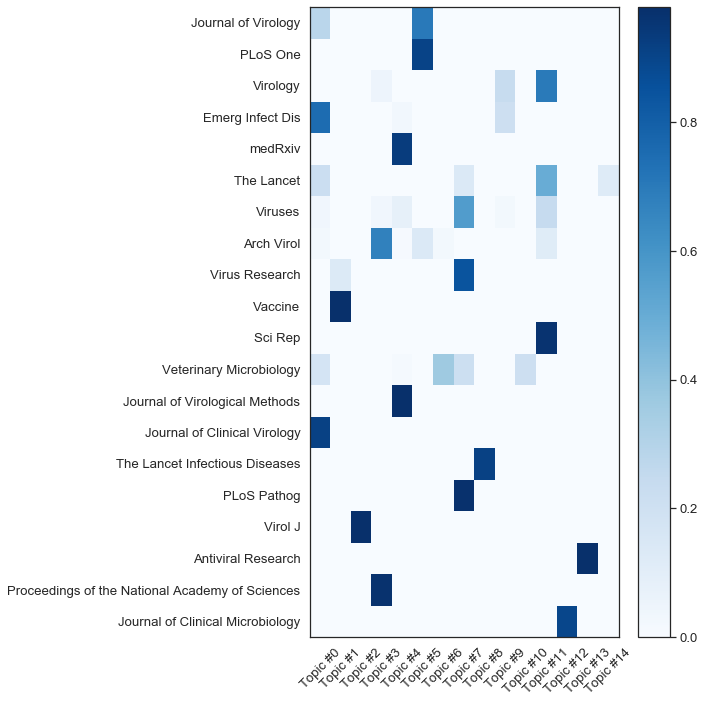

In [41]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics, norm=None, cmap='Blues')
plt.yticks(np.arange(how_many)+0.5, journal_names_reduced)
plt.xticks(np.arange(model_j.num_topics)+0.5, ["Topic #"+str(n) for n in range(model_j.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.savefig("figures/topic_model_top_journals.pdf")
plt.show()

In [42]:
# TODO: match topics here with topics above, or directly work with the topics above for all journals

#### Correlated topic model

With tomotopy.

In [20]:
import tomotopy as tp

params = {'num_topics': 15,'passes': 10, 'random_state': seed}
mdl = tp.CTModel(k=params['num_topics'],min_cf=min_wordcount,min_df=2)
for doc in docs:
    mdl.add_doc(doc)

for i in range(0, 300, 25):
    mdl.train(25)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

Iteration: 0	Log-likelihood: -7.952682493160052
Iteration: 25	Log-likelihood: -7.580369381135443
Iteration: 50	Log-likelihood: -7.18383278109214
Iteration: 75	Log-likelihood: -6.8724311307285975
Iteration: 100	Log-likelihood: -6.692760464720625
Iteration: 125	Log-likelihood: -6.606490762439231
Iteration: 150	Log-likelihood: -6.559329422748022
Iteration: 175	Log-likelihood: -6.525913741406331
Iteration: 200	Log-likelihood: -6.511598970528629
Iteration: 225	Log-likelihood: -6.505459009571211
Iteration: 250	Log-likelihood: -6.502068255244552
Iteration: 275	Log-likelihood: -6.496780764407905


In [21]:
for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=7))

Top 10 words of topic #0
[('virus', 0.15144172310829163), ('infection', 0.08410266786813736), ('viral', 0.06533856689929962), ('human', 0.049547962844371796), ('host', 0.02498638443648815), ('role', 0.022717703133821487), ('type', 0.019872356206178665)]
Top 10 words of topic #1
[('disease', 0.04943253844976425), ('model', 0.026093825697898865), ('system', 0.024129800498485565), ('factor', 0.019617542624473572), ('development', 0.01689882203936577), ('change', 0.01245930790901184), ('important', 0.011822817847132683)]
Top 10 words of topic #2
[('influenza', 0.04502635821700096), ('day', 0.021252159029245377), ('child', 0.02024831809103489), ('p', 0.015896260738372803), ('pandemic', 0.013804404996335506), ('pneumonia', 0.013598648831248283), ('age', 0.013355482369661331)]
Top 10 words of topic #3
[('strain', 0.024857645854353905), ('effect', 0.022751107811927795), ('increase', 0.02177148498594761), ('level', 0.021649908274412155), ('suggest', 0.02157275564968586), ('different', 0.0204645

In [25]:
# topics over time

df_local = df_cord19[pd.notnull(df_cord19["title_abstract"])]
publication_years = df_local.publication_year.tolist()
dois = df_local.doi.tolist()
topics_corr = np.zeros((len(docs),params['num_topics']))

for n,doc in enumerate(mdl.docs):
    for m,t in enumerate(doc.get_topic_dist()):
        topics_corr[n][m] = t

In [26]:
df_topics_corr = pd.DataFrame(topics_corr)

In [27]:
df_topics_corr["year"] = publication_years
df_topics_corr["doi"] = dois

In [28]:
from_which_year = 1980

grouped_corr = df_topics_corr.groupby('year')
df_grouped_corr = grouped_corr.aggregate(np.mean)
df_grouped_corr = df_grouped_corr[df_grouped_corr.index >= from_which_year]
#df_grouped

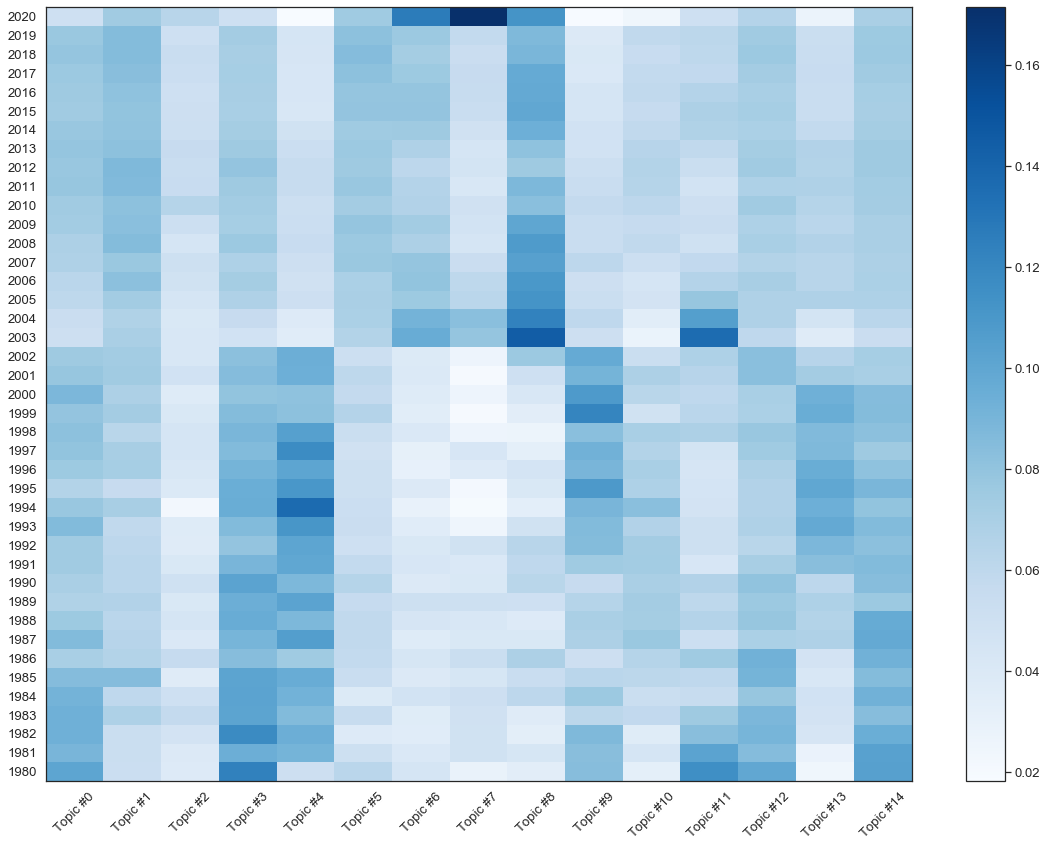

In [29]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped_corr.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped_corr.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped_corr.index.values])
plt.xticks(np.arange(df_grouped_corr.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
#plt.savefig("figures/corr_topic_model_all_time_15.pdf")
plt.show()

In [30]:
# topic correlations

topics_correlations = np.zeros((mdl.k,mdl.k))

for k in range(mdl.k):
    for m,c in enumerate(mdl.get_correlations(k)):
        topics_correlations[k][m] = c

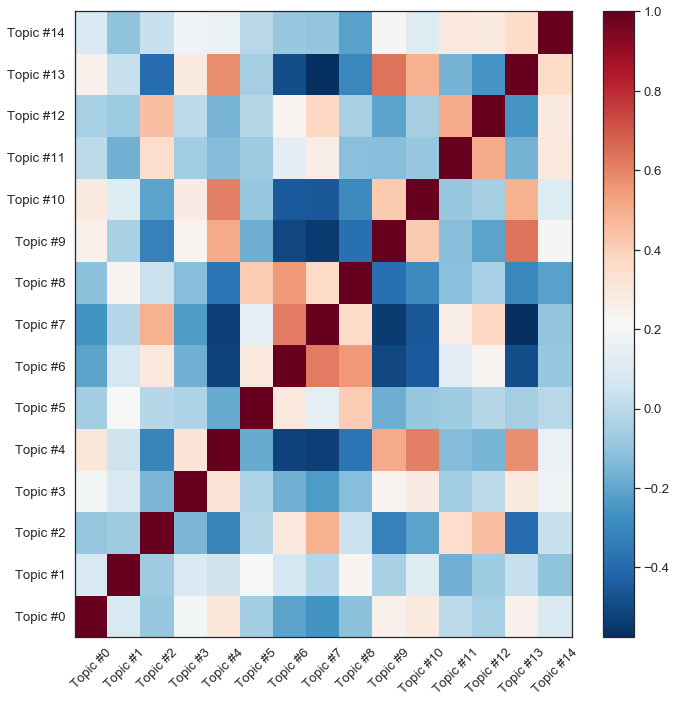

In [31]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)])
plt.xticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
#plt.savefig("figures/corr_topic_model_correlations_15.pdf")

#### Language modelling, semantic spaces and clustering

Future work.